# TP3: Équation d'advection

Le but de ce TP est de calculer numériquement de deux façons différentes la solution du problème de diffusion avec conditions au bord de type Neumann,
$$
\begin{cases}
    \partial_t u(x,t) + c \partial_x u = 0, & (x,t) \in (0,L) \times (0, T), \\
    u(x, 0) = u_0(x), \\
    u(0, t) = 0 .
\end{cases}
$$

Pour les applications, on choisira $L = 1$, $T = 0.5$ et $c = 1$. La condition initiale sera fixée à 
$$
u_0(x) = \exp \bigl( -200 (x - 1/4)^2 \bigr) . 
$$

In [1]:
using LinearAlgebra # fourni notamment Bidiagonal, Tridiagonal, I et mul!
using Plots

const L = 1.0;
const T = 0.5;
const c = 1.0;

### 1. Partie analytique

1.a) Implémenter une fonctions `u0` qui correspond à la condition initiale.

1.b) Implémenter une fonction `u_ex` qui prend en entrée `x` et `t` et qui renvoie la solution exacte en ce point en utilisant `u0`.

In [2]:
u0(x) = exp(-200(x - 0.25)^2)
u_ex(x, t) = u0(x - c*t)

u_ex (generic function with 1 method)

### 2. Schéma upwind

#### 2.1/ Calcul de la solution

2.1.a) Préciser $\beta$ et $A_u$ de sorte que le schéma upwind s'écrive $U^{n+1} = U^n - \beta A_u U^n$.  
$\beta = C_{CFL} = c \frac{\Delta t}{\Delta x} $ et $A_u =$ matrice bidiagonal de diagonale principale unitaire et diagonale inférieur =-1

2.1.b) Implémenter une fonction `upwind_matrix` qui crée la matrice $A_u$ à partir du nombre de points de discrétisations. On utilisera la structure `Bidiagonal` ou `Tridiagonal` pour limiter la mémoire allouée.

2.1.c) Écrire une fonction `simulate_upwind` qui prend en entrée une fonction de condition initiale `u0`, le nombre de points de discrétisations `Nx` et le nombre CFL `cfl`, et qui calcule par méthode upwind la solution numérique jusqu'au temps $T = 0.5$. 

Si $T$ n'est pas un multiple de $\Delta t$, on calculera la solution jusqu'au temps $t = N_t \Delta t \geq T$ avec $N_t = \lceil T / \Delta t \rceil$ (regarder la documentation de la fonction `ceil`). La fonction `simulate_upwind` devra renvoyer le maillage `x`, le temps final `t`, et le vecteur solution `u` à cet instant final.

In [3]:
function upwind_matrix(Nx)
    dv = fill(1.0, Nx)
    ev = fill(-1.0, Nx-1)
    return Bidiagonal(dv, ev, :L)
end

function upwind_loop!(u, u_tmp, S, Nt)
    for _ in 1:Nt
        mul!(u_tmp, S, u)
        u .= u_tmp
    end
end

function simulate_upwind(u0, Nx, cfl)
    # initialisation du maillage et du pas de temps
    x = range(0, L, length=Nx)
    dx = x[2] - x[1]
    dt = cfl * dx / c
    Nt = ceil(Int64, T / dt)
    t = Nt * dt
    # condition initiale
    U = u0.(x)
    u_tmp = similar(U)

    # initialisation de la matrice de discrétisation
    S = (I - cfl * upwind_matrix(Nx))
    # calcul de la solution
    upwind_loop!(U, u_tmp, S, Nt)

    return x, t, U
end;

### 2.2/ Étude qualitative de la solution

Avec $N_x = 101$, tracer la solution au temps final pour $C_{\rm CFL} \in \{0.1, 0.5, 1\}$. Que remarque-t-on ?

0.5

0.5

0.5

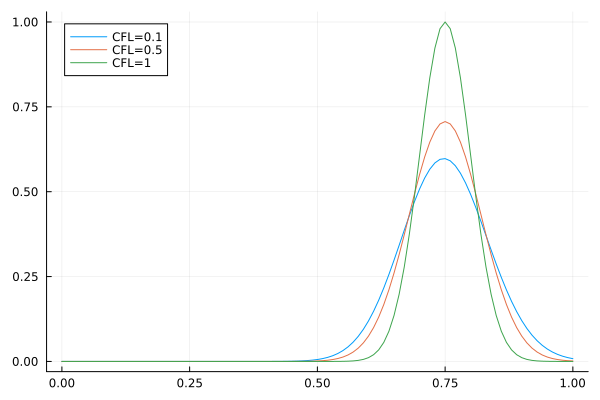

In [4]:
Nx = 101
cfl = [0.1, 0.5, 1]

x, t1, U1 = simulate_upwind(u0, Nx, cfl[1])
x, t2, U2 = simulate_upwind(u0, Nx, cfl[2])
x, t3, U3 = simulate_upwind(u0, Nx, cfl[3])
display(t1)
display(t2)
display(t3)

p = plot()
plot!(p, x, U1, label="CFL=0.1")
plot!(p, x, U2, label="CFL=0.5")
plot!(p, x, U3, label="CFL=1")display(t1)
display(t2)
display(t3)
# on a le meme temps final: 0.5 OK

#### 2.3/ Erreur du schéma

Tracer l’erreur (en normes $L^1$ et $L^2$) entre la solution exacte et la solution approchée en fonction de la finesse du maillage ($N_x$ entre $101$ et $10001$), en échelle logarithmique et pour différentes valeurs du nombre CFL.

L'erreur $e_p$ en norme $L^p$, pour $p \geq 1$, est définie par
$$ e_p(N_x, C_{\rm CFL}) = \left( \Delta x \sum_{j=1}^{N_x} \left| u_j^{N_t} - u_{\rm ex}(x_j, N_t \Delta t) \right|^p \right)^{1/p} . $$
On pourra aussi utiliser la fonction `norm` de `LinearAlgebra`.

In [5]:
using LinearAlgebra: norm
all_Nx = ceil.(Int64, 10.0 .^ range(2, 4, length=8)) .+ 1
cfl1, cfl2, cfl3 = 0.1, 0.5, 0.8
err1_l1, err2_l1, err3_l1 = zeros(length(all_Nx)), zeros(length(all_Nx)), zeros(length(all_Nx))
err1_l2, err2_l2, err3_l2 = zeros(length(all_Nx)), zeros(length(all_Nx)), zeros(length(all_Nx))

for (i, Nx) in enumerate(all_Nx)
    x, t2, u2 = simulate_upwind(u0, Nx, cfl2)
    x, t1, u1 = simulate_upwind(u0, Nx, cfl1)
    x, t3, u3 = simulate_upwind(u0, Nx, cfl3)

    err1_l1[i] = norm(u1 - u_ex.(x, t1), 1)
    err2_l1[i] = norm(u2 - u_ex.(x, t2), 1)
    err3_l1[i] = norm(u3 - u_ex.(x, t3), 1)
    err1_l2[i] = norm(u1 - u_ex.(x, t1), 2)
    err2_l2[i] = norm(u2 - u_ex.(x, t2), 2)
    err3_l2[i] = norm(u3 - u_ex.(x, t3), 2)
end

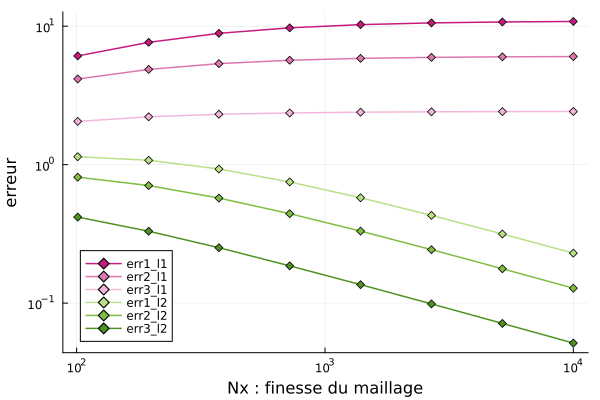

In [6]:
colors = palette(:PiYG_9)
p = plot(xscale=:log10, yscale=:log10, xlabel="Nx : finesse du maillage", ylabel="erreur", legend=:bottomleft)
plot!(p, all_Nx, err1_l1, label="err1_l1", color=colors[1], linewidth=1.5, marker=:d)
plot!(p, all_Nx, err2_l1, label="err2_l1", color=colors[2], linewidth=1.5, marker=:d)
plot!(p, all_Nx, err3_l1, label="err3_l1", color=colors[3], linewidth=1.5, marker=:d)

plot!(p, all_Nx, err1_l2, label="err1_l2", color=colors[7], linewidth=1.5, marker=:d)
plot!(p, all_Nx, err2_l2, label="err2_l2", color=colors[8], linewidth=1.5, marker=:d)
plot!(p, all_Nx, err3_l2, label="err3_l2", color=colors[9], linewidth=1.5, marker=:d)

### 3. Schéma centré

3.a) Quelle est la matrice $A_c$ pour que le schéma centré s'écrive $U^{n+1} = U^n - \beta A_c U^n$ avec $\beta = c \frac{\Delta t}{\Delta x}$.

3.b) Reprendre les codes de la partie précédente pour définir `matrix_centered` et `simulate_centered`.

3.c) Effectuer la même analyse sur la solution et l'erreur pour ce schéma. Il faudra prendre $C_{\rm CFL} \ll 1$.

In [7]:
function centered_matrix(Nx)
    return Tridiagonal(fill(-1.0, Nx-1), zeros(Nx), fill(-1.0, Nx-1))
end

function centered_loop!(u, u_tmp, S, Nt)
    @inbounds for _ in 1:Nt
        mul!(u_tmp, S, u)
        u .= u_tmp
    end
end

function simulate_centered(u0, Nx, cfl)
    # initialisation du maillage et du pas de temps
    x = range(0, L, length=Nx) # L def au debut du document
    dx = x[2] - x[1]
    dt = cfl * dx
    Nt = ceil(Int64, T / dt) # T def au debut du document
    t = Nt * dt

    # conditions initiales
    u = u0.(x)
    u_tmp = similar(u)
    # initialisation de la matrice de discrétisation
    S = (I + cfl * centered_matrix(Nx))
    # calcul de la solution
    centered_loop!(u, u_tmp, S, Nt)

    return x, t, u
end;

In [8]:
centered_matrix(4)

4×4 Tridiagonal{Float64, Vector{Float64}}:
  0.0  -1.0    ⋅     ⋅ 
 -1.0   0.0  -1.0    ⋅ 
   ⋅   -1.0   0.0  -1.0
   ⋅     ⋅   -1.0   0.0

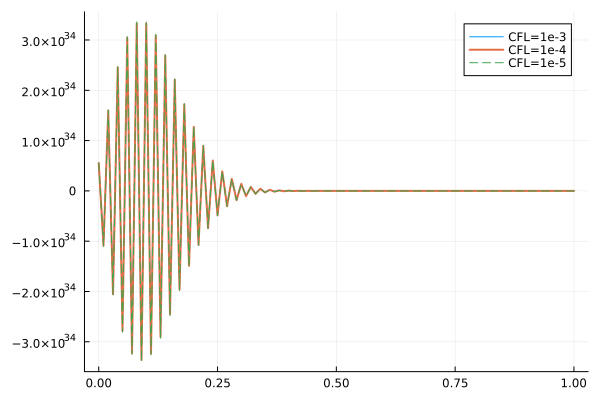

In [9]:
Nx = 101
cfl1, cfl2, cfl3 = 1e-3, 1e-4, 1e-5

x, t1, U1 = simulate_centered(u0, Nx, cfl1)
x, t2, U2 = simulate_centered(u0, Nx, cfl2)
x, t3, U3 = simulate_centered(u0, Nx, cfl3)
# display(t1)
# display(t2)
# display(t3)
# tmp final : OK

p = plot()
plot!(p, x, U1, label="CFL=1e-3")
plot!(p, x, U2, label="CFL=1e-4", linewidth=2)
plot!(p, x, U3, label="CFL=1e-5", linestyle=:dash)
# on ne voit pas tres bien mais les 3 courbes sont supperposé
# schema inconditionellement instable, inutilisable

In [10]:
all_Nx = ceil.(Int64, 10.0 .^ range(2, 4, length=3)) .+ 1 # j'ai reduit c'etait trop long
cfl = 1e-2
err1_l1, err1_l2 = zeros(length(all_Nx)), zeros(length(all_Nx))

for (i, Nx) in enumerate(all_Nx)
    x, t1, u1 = simulate_centered(u0, Nx, cfl)

    err1_l1[i] = norm(u1 - u_ex.(x, t1), 1)
    err1_l2[i] = norm(u1 - u_ex.(x, t1), 2)
end
# temps d'execution :
# cfl 1e10-2 -> 6s
# cfl 1e10-3 -> 1min
# cfl 1e10-2 -> interminable .... pas reussi meme apres 5min

In [11]:
display(err1_l1)
display(x)

3-element Vector{Float64}:
   2.101286374804863e35
  Inf
 NaN

0.0:0.0001:1.0

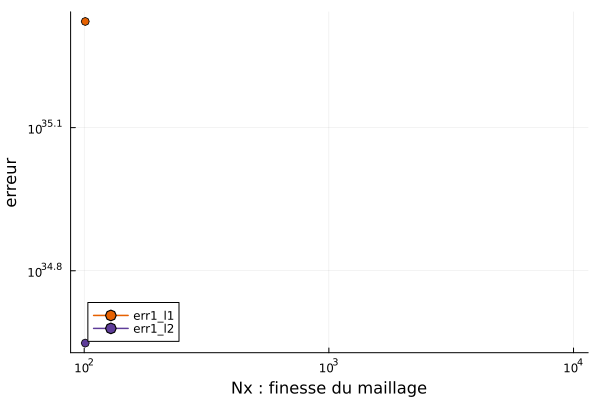

In [12]:
colors = palette(:PuOr_4)
p = plot(xscale=:log10, yscale=:log10, xlabel="Nx : finesse du maillage", ylabel="erreur", legend=:bottomleft)
plot!(p, all_Nx, err1_l1, label="err1_l1", color=colors[1], linewidth=1.5, marker=:o)
plot!(p, all_Nx, err1_l2, label="err1_l2", color=colors[4], linewidth=1.5, marker=:o)
# difficile d'afficher les abscisse avec des ticks de 0 ou trop petits

### 4. Un peu d'animation!

4.a) Reprendre les codes de simulation précédent en ajoutant un paramètre `save_every` qui sauvegarde la solution dans `u` (qui sera donc un vecteur de vecteurs) tous les `save_every` pas de temps. La fonction devra renvoyer `x` le maillage, `t` les temps auquels la solution est sauvegardée, et `u` qui contient la solution à chacun de ces temps.

4.b) Créer une vidéo ou un gif qui trace l'évolution de la solution au cours du temps. La syntaxe est disponible au lien suivant : https://docs.juliaplots.org/latest/#simple-is-beautiful